In [1]:
%%capture
#This is to fix the datasets.load_dataset compatibility with latest fsspec
!pip install fsspec==2023.9.2
!pip install numpy==1.26.3

#Imports





In [3]:
# %%capture
import pandas as pd
import numpy as np
import datasets
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
from transformers import AutoTokenizer, TFDistilBertForSequenceClassification
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Ingest Data

In [2]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.8.1
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.11.15
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.21.0
astropy                               7.1.0
astropy-iers-data                     0.2025.7.14.0.

In [11]:
def ingest_data():
  ds = datasets.load_dataset("google-research-datasets/go_emotions")
  return ds

In [87]:
ds = ingest_data()

# EDA

In [18]:
# Number of examples in each split
splits = ["test","train","validation"]
for split in splits:
  print(f"{split} : " +str(ds[split].num_rows))

test : 5427
train : 43410
validation : 5426


In [19]:
# Available keys in features split
ds['test'].features.keys()

dict_keys(['text', 'labels', 'id'])

In [20]:
# Exploring data entries
print(ds['test'].to_pandas().head())
print(ds['test'].to_pandas().tail())

                                                text labels       id
0  I’m really sorry about your situation :( Altho...   [25]  eecwqtt
1    It's wonderful because it's awful. At not with.    [0]  ed5f85d
2  Kings fan here, good luck to you guys! Will be...   [13]  een27c3
3  I didn't know that, thank you for teaching me ...   [15]  eelgwd1
4  They got bored from haunting earth for thousan...   [27]  eem5uti
                                                   text labels       id
5422  Thanks. I was diagnosed with BP 1 after the ho...   [15]  efeeasc
5423                             Well that makes sense.    [4]  ef9c7s3
5424                                Daddy issues [NAME]   [27]  efbiugo
5425  So glad I discovered that subreddit a couple m...    [0]  efbvgp9
5426  Had to watch "Elmo in Grouchland" one time too...   [27]  edtjpv6


In [21]:
# All available labels and corresponding integer
label_list = ds['test'].features['labels'].feature.names
label_dict = {x:y for x,y in enumerate(label_list)}
label_dict

{0: 'admiration',
 1: 'amusement',
 2: 'anger',
 3: 'annoyance',
 4: 'approval',
 5: 'caring',
 6: 'confusion',
 7: 'curiosity',
 8: 'desire',
 9: 'disappointment',
 10: 'disapproval',
 11: 'disgust',
 12: 'embarrassment',
 13: 'excitement',
 14: 'fear',
 15: 'gratitude',
 16: 'grief',
 17: 'joy',
 18: 'love',
 19: 'nervousness',
 20: 'optimism',
 21: 'pride',
 22: 'realization',
 23: 'relief',
 24: 'remorse',
 25: 'sadness',
 26: 'surprise',
 27: 'neutral'}

In [22]:
# 5 examples from every emotion , class distribution
class_dist = {}
for i in range(28):
  example_text = [x for x in ds['test'] if i in x['labels']]
  class_dist[i] = len(example_text)
  print("Emotion : " + label_dict[i])
  for j in example_text[:5]:
    print(j['text'])

Emotion : admiration
It's wonderful because it's awful. At not with.
It's great that you're a recovering addict, that's cool. Have you ever tried DMT?
This guy is a little turd but I love him so dearly. I'll pass on your kisses :)
in what universe? lol the mr. blue sky cover is one of the best on the album imo.
Lol looks delicious
Emotion : amusement
Lol! But I love your last name though. XD
Triggered:: Welp guess it's time for me to re-up lol
I know you're joking, but there are people here either stupid or desperate enough to believe and perpetuate such idiocy. 
in what universe? lol the mr. blue sky cover is one of the best on the album imo.
You sure? They seem so much brighter on screen lol
Emotion : anger
Eff your video - love Canada 🇨🇦 Stupid geolock
That's too many pills
Talk about an oldddd school shit coin.
How dare you! Don’t you know seatbelts cause autism!
Damnit Morty! D'you see wha-rrrgh-t you've done!? We're fucked Morty, the squirrels - they're recruiting dolphins now Mo

In [23]:
# Distribution of classes
class_dist

{0: 504,
 1: 264,
 2: 198,
 3: 320,
 4: 351,
 5: 135,
 6: 153,
 7: 284,
 8: 83,
 9: 151,
 10: 267,
 11: 123,
 12: 37,
 13: 103,
 14: 78,
 15: 352,
 16: 6,
 17: 161,
 18: 238,
 19: 23,
 20: 186,
 21: 16,
 22: 145,
 23: 11,
 24: 56,
 25: 156,
 26: 141,
 27: 1787}

Max length = 184
Average length = 67.82476506357104


(array([597., 933., 857., 906., 769., 641., 432., 238.,  42.,  12.]),
 array([  5. ,  22.9,  40.8,  58.7,  76.6,  94.5, 112.4, 130.3, 148.2,
        166.1, 184. ]),
 <BarContainer object of 10 artists>)

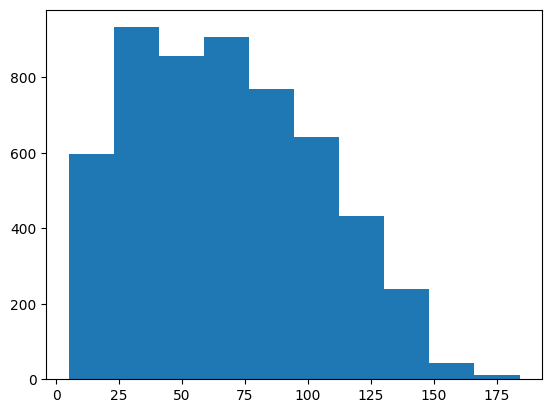

In [24]:
# Max , avg len of all
lenArray = []
maxLen = 0
avgLen = 0
for x in ds["test"]:
  lengthOfText = len(x['text'])
  maxLen = max(maxLen,lengthOfText)
  avgLen += lengthOfText
  lenArray.append(lengthOfText)
print(f"Max length = {maxLen}")
print(f"Average length = {avgLen/ds['test'].num_rows}")
plt.hist(lenArray)


In [108]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [88]:
# Preprocessing our data and making it training ready
def tokenize_input(example):
  tokenized = tokenizer(example["text"],padding = "max_length",truncation=True,max_length = 180)
  updated_example = {"input_ids":tokenized["input_ids"],"attention_mask":tokenized["attention_mask"],"labels":example["labels"],"id":example["id"]}
  return updated_example
def one_hot_labels(example):
  one_hot_arr = [0]*28
  for i in example['labels']:
    one_hot_arr[i] = 1
  example['labels'] = one_hot_arr
  return example
def preprocessing_data(ds):
  # Train ds pipeline
  # Right now its a datasets , dataset . We tokenize it and then convert it into a tf dataset
  ds['train'] = ds['train'].map(one_hot_labels)
  ds['train'] = ds['train'].map(tokenize_input)
  # ds['test'] = ds['test'].map(tokenize_input)
  # ds['validation'] = ds['validation'].map(tokenize_input)

  # Converting tokenized outputs into tf dataset
  # ds['train'] = ds['train'].to_tf_dataset(
  #     columns = ['input_ids',"attention_mask"],
  #     label_cols = 'labels',
  #     output_type=tf.int64
  # ).shuffle(buffer_size = 200).batch(32)

  # ds['test'] = ds['test'].to_tf_dataset(
  #     columns = ['input_ids',"attention_mask"],
  #     label_cols = 'labels',
  # ).shuffle(buffer_size = 200).batch(32)

  # ds['validation'] = ds['calidation'].to_tf_dataset(
  #     columns = ['input_ids',"attention_mask"],
  #     label_cols = 'labels',
  # ).shuffle(buffer_size = 200).batch(32)

preprocessing_data(ds)

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Streaming output truncated to the last 5000 lines.
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

In [86]:
len_arr = [len(x['labels']) for x in ds['train']]
len_arr

[28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,
 28,


In [76]:
# max(len_arr)
ds['train'][0]['labels']

[[0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  1.0]]

In [89]:
# Converting tokenized outputs into tf dataset
tf_ds = ds['train'].to_tf_dataset(
    columns=['input_ids',"attention_mask"],
    label_cols="labels",
    batch_size = 32,
    shuffle = True
)

In [109]:
# Exploring the model
model = TFDistilBertForSequenceClassification.from_pretrained(
    model_name,
    num_labels = 28,
    problem_type = "multi_label_classification"
)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [ ]:
# dir(model)
# model.name
# model.layers
# model.framework
# model.metrics
# model.num_labels
# model.num_parameters()
# model.summary()

In [128]:
def compile_model(model,optimizer = "adam",loss_function = tf.keras.losses.CategoricalCrossentropy(),metrics = ['accuracy']):
  compile_config = {
      "optimizer": optimizer,
      "loss": loss_function,
      "metrics": metrics
  }
  model.compile(**compile_config)
  return model
model = compile_model(model=model)

In [ ]:
def train_model(model,tf_ds):
  model.fit(
    x=tf_ds,
    batch_size=32,
    epochs=1
  )
train_model(model,tf_ds)

# Scraping

In [ ]:
%%capture
# Youtube comments scraper part
# Get the package to scrape
# Imports
from itertools import islice
from youtube_comment_downloader import *

In [ ]:
downloader = YoutubeCommentDownloader()
comments_1 = downloader.get_comments_from_url(youtube_url_1, sort_by=SORT_BY_POPULAR)
comments_1 = [comment for comment in islice(comments_1, 3000)]
comments_2 = downloader.get_comments_from_url(youtube_url_2, sort_by=SORT_BY_POPULAR)
comments_2 = [comment for comment in islice(comments_2, 3000)]

In [ ]:
print(comments_1[0])
print(comments_2[0])
print(len(comments_1))
print(len(comments_2))  

In [ ]:
text_time_dict_1 = {x['text']:x['time'] for x in comments_1}
text_time_dict_2 = {x['text']:x['time'] for x in comments_2}

In [ ]:
%%capture
# Data Drift Detection Part
from evidently import Report
from evidently.presets import DataDriftPreset
import pandas as pd

In [ ]:
week1_predictions = [2,3,4,5,7,8,9]
week2_predictions = [2,3,4,5,2,2,1]
week1_df = pd.DataFrame({
    "emotion": week1_predictions   # List of model-predicted labels
})
week2_df = pd.DataFrame({
    "emotion": week2_predictions   # List of model-predicted labels
})

In [ ]:
report = Report(metrics=[DataDriftPreset()])
my_eval = report.run(reference_data=week1_df, current_data=week2_df)
my_eval.save_html("files.html")
my_eval

In [ ]:
my_eval.dict()